[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pytextbook/pytextbook/blob/main/8.0.%20inflearn-newyear-event-text-analysis.ipynb) 


## 인프런 2020년 새해 다짐 이벤트 댓글 분석
* https://www.inflearn.com/pages/newyear-event-20200102
* 영상 튜토리얼 : [댓글 수백 수천개 분석하기?! [1/5] 이벤트 데이터 크롤링 feat. 인프런 새해 다짐 이벤트 - YouTube](https://www.youtube.com/watch?v=OUSwQk79H8I&list=PLaTc2c6yEwmohRzCxWQqJ7Z9aqc-sQ5gC)

## 라이브러리 로드

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

## 시각화를 위한 한글폰트 설정

In [2]:
# !pip install koreanize-matplotlib

<AxesSubplot: title={'center': '한글'}>

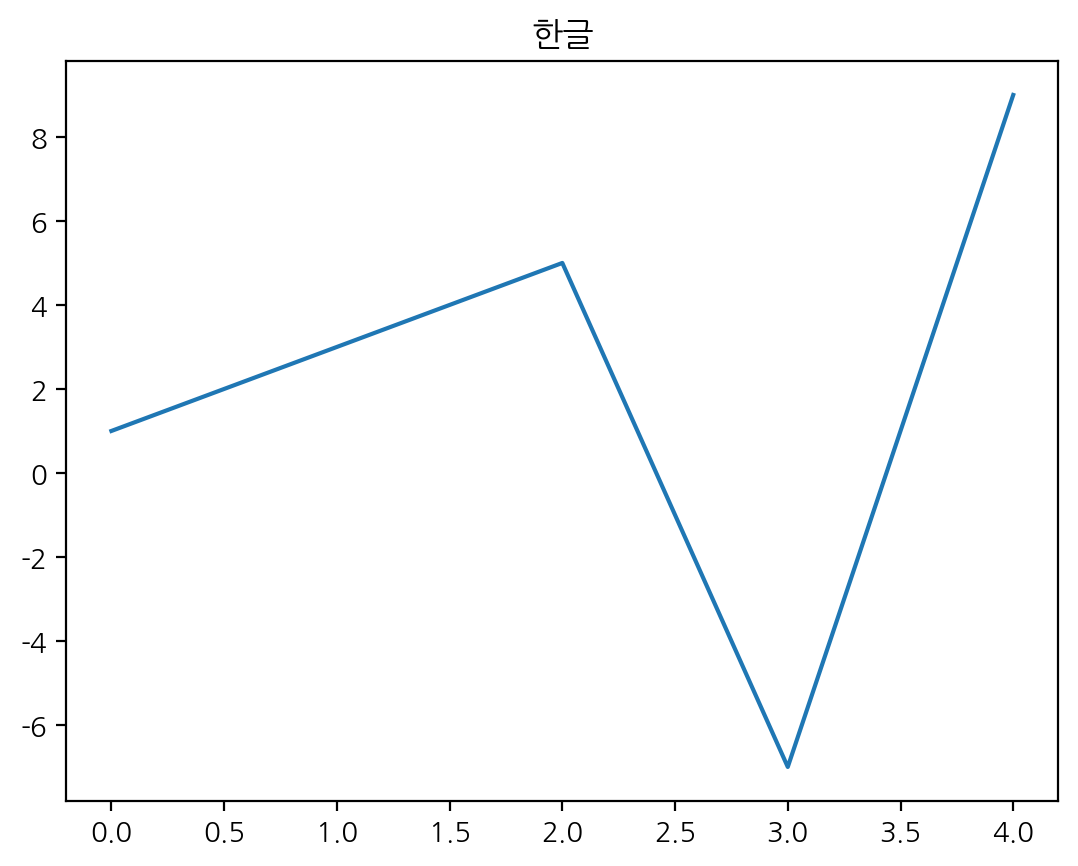

In [3]:
import koreanize_matplotlib

# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

pd.Series([1, 3, 5, -7, 9]).plot(title="한글")

## 수집된 파일 로드하기

In [4]:
# df 라는 변수에 이벤트 댓글 파일을 로드합니다.
df = pd.read_csv("https://bit.ly/inflearn-event-text-csv")
df.shape

(2449, 1)

In [5]:
# head 로 일부보기
df.head()

,text
0,2020년 목표: 스프링 열심히 공부하서 직장에서 사랑받고 싶어요!!\n관심 있는 ...
1,"2020년 목표: C++ 열심히 공부해서, 학교에서 꼭 A 맞기..!! \n관심있는..."
2,2020년 목표 : 리액트 공부하기
3,40대 프로그래밍 시작! : 우리를 위한 프로그래밍 : 파이썬 중급
4,2020년 목표 : 돌머리 비전공자가 멋진 전공자 되기!


In [6]:
# tail 로 일부보기
df.tail()

,text
2444,"작년 한해도 일이 바쁘다, 야근해서 힘들다는 핑계로 ***님의 JPA 강의를 또 스..."
2445,저는 졸업을 1년 남기고 있는 컴퓨터공학과 학생입니다. 졸업 프로젝트로 웹/앱 개발...
2446,"에프터 이펙트를 써본 적은 있는데, 매번 기초만 배우다 말았어요. 이걸 할 줄 안다..."
2447,저번에 인프런에서 페이스북 마케팅 강의를 듣고 많은 도움을 받았습니다. 마케팅 업무...
2448,인프런 0호 팀원이에요!\n그동안 서비스 개발 때문에 js 를 많이 했었는데 앞으론...


## 데이터 전처리

### 네트워크 오류 등으로 발생한 중복 입력 값을 제거
* 빈도 수 중복을 방지하기 위해

In [7]:
# drop_duplicates 를 통해 중복을 제거하며, 이때 마지막 글을 남김
print(df.shape)
df = df.drop_duplicates(["text"], keep="last")
print(df.shape)

(2449, 1)
(2410, 1)


### 원본은 따로 보존

In [8]:
# 전처리 전에 원본을 보존하기 위해 origin_text 라는 컬럼에 복
df["origin_text"] = df["text"]
df.head()

,text,origin_text
0,2020년 목표: 스프링 열심히 공부하서 직장에서 사랑받고 싶어요!!\n관심 있는 ...,2020년 목표: 스프링 열심히 공부하서 직장에서 사랑받고 싶어요!!\n관심 있는 ...
1,"2020년 목표: C++ 열심히 공부해서, 학교에서 꼭 A 맞기..!! \n관심있는...","2020년 목표: C++ 열심히 공부해서, 학교에서 꼭 A 맞기..!! \n관심있는..."
3,40대 프로그래밍 시작! : 우리를 위한 프로그래밍 : 파이썬 중급,40대 프로그래밍 시작! : 우리를 위한 프로그래밍 : 파이썬 중급
4,2020년 목표 : 돌머리 비전공자가 멋진 전공자 되기!,2020년 목표 : 돌머리 비전공자가 멋진 전공자 되기!
5,2020 년목표: 비전공자(경영)가 전공자(it) 되기!!!,2020 년목표: 비전공자(경영)가 전공자(it) 되기!!!


### 소문자 변환

In [9]:
# "text" 파이썬은 대소문자를 구분하기 때문에 데이터 필터링을 위해 대문자를 모두 소문자로 변경
df["text"] = df["text"].str.lower()

In [10]:
# 같은 의미의 단어를 하나로 통일 예) python => 파이썬
# replace 는 텍스트가 완전히 일치될 때만 사용할 수 있음
# 일부만 일치한다면 str.replace 를 사용하면 원하는 텍스트로 변경이 가능
df["text"] = df["text"].str.replace(
    "python", "파이썬").str.replace(
    "pandas", "판다스").str.replace(
    "javascript", "자바스크립트").str.replace(
    "java", "자바").str.replace(
    "react", "리액트")

### 텍스트로 관심 강의 분리

In [11]:
# 이 이벤트에는 "관심강의"라는 텍스트가 있음
# "관심강의"를 기준으로 텍스트를 분리하고 관심강의 뒤에 있는 텍스트를 가져옴
# 대부분 "관심강의"라는 텍스트를 쓰고 뒤에 강의명을 쓰기 때문
# 전처리한 내용은 실수를 방지하기 위해 "course" 라는 새로운 컬럼에 담고
# "관심 강의", "관심 강좌" 에 대해서도 똑같이 전처리
# ":" 특수문자를 빈문자로 변경

df["course"] = df["text"].apply(lambda x: x.split("관심강의")[-1])
df["course"] = df["course"].apply(lambda x: x.split("관심 강의")[-1])
df["course"] = df["course"].apply(lambda x: x.split("관심 강좌")[-1])
df["course"] = df["course"].str.replace(":", "")
df["course"].head()

0    2020년 목표 스프링 열심히 공부하서 직장에서 사랑받고 싶어요!!\n관심 있는 강...
1    2020년 목표 c++ 열심히 공부해서, 학교에서 꼭 a 맞기..!! \n관심있는 ...
3                  40대 프로그래밍 시작!  우리를 위한 프로그래밍  파이썬 중급
4                       2020년 목표  돌머리 비전공자가 멋진 전공자 되기!
5                     2020 년목표 비전공자(경영)가 전공자(it) 되기!!!
Name: course, dtype: object

In [12]:
# "text", "course" 전처리 내용 미리보기
df[["text", "course"]].head()

,text,course
0,2020년 목표: 스프링 열심히 공부하서 직장에서 사랑받고 싶어요!!\n관심 있는 ...,2020년 목표 스프링 열심히 공부하서 직장에서 사랑받고 싶어요!!\n관심 있는 강...
1,"2020년 목표: c++ 열심히 공부해서, 학교에서 꼭 a 맞기..!! \n관심있는...","2020년 목표 c++ 열심히 공부해서, 학교에서 꼭 a 맞기..!! \n관심있는 ..."
3,40대 프로그래밍 시작! : 우리를 위한 프로그래밍 : 파이썬 중급,40대 프로그래밍 시작! 우리를 위한 프로그래밍 파이썬 중급
4,2020년 목표 : 돌머리 비전공자가 멋진 전공자 되기!,2020년 목표 돌머리 비전공자가 멋진 전공자 되기!
5,2020 년목표: 비전공자(경영)가 전공자(it) 되기!!!,2020 년목표 비전공자(경영)가 전공자(it) 되기!!!


## 띄어 쓰기를 제거한 텍스트에서 키워드 추출
* TIOBE 프로그래밍 언어 순위 : [index | TIOBE - The Software Quality Company](https://www.tiobe.com/tiobe-index/?fbclid=IwAR34dJfgDHq2DK0C6X3g8IsUno2NhOiikMyxT6fw9SoyujFhy5FPvQogMoA)

In [13]:
# 특정 키워드가 들어가는 댓글을 찾음
search_keyword = ['머신러닝', '딥러닝', '파이썬', '판다스', '공공데이터',
                  'django', '크롤링', '시각화', '데이터분석', 
                  '웹개발', '엑셀', 'c', '자바', '자바스크립트', 
                  'node', 'vue', '리액트']

# for 문을 통해 해당 키워드가 있는지 여부를 True, False값으로 표시하도록 함
# 키워드에 따라 컬럼을 새로 만듭니다.
for keyword in search_keyword:
    df[keyword] = df["course"].str.contains(keyword)

In [14]:
# 미리보기
df.head()

,text,origin_text,course,머신러닝,딥러닝,파이썬,판다스,공공데이터,django,크롤링,시각화,데이터분석,웹개발,엑셀,c,자바,자바스크립트,node,vue,리액트
0,2020년 목표: 스프링 열심히 공부하서 직장에서 사랑받고 싶어요!!\n관심 있는 ...,2020년 목표: 스프링 열심히 공부하서 직장에서 사랑받고 싶어요!!\n관심 있는 ...,2020년 목표 스프링 열심히 공부하서 직장에서 사랑받고 싶어요!!\n관심 있는 강...,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
1,"2020년 목표: c++ 열심히 공부해서, 학교에서 꼭 a 맞기..!! \n관심있는...","2020년 목표: C++ 열심히 공부해서, 학교에서 꼭 A 맞기..!! \n관심있는...","2020년 목표 c++ 열심히 공부해서, 학교에서 꼭 a 맞기..!! \n관심있는 ...",False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
3,40대 프로그래밍 시작! : 우리를 위한 프로그래밍 : 파이썬 중급,40대 프로그래밍 시작! : 우리를 위한 프로그래밍 : 파이썬 중급,40대 프로그래밍 시작! 우리를 위한 프로그래밍 파이썬 중급,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,2020년 목표 : 돌머리 비전공자가 멋진 전공자 되기!,2020년 목표 : 돌머리 비전공자가 멋진 전공자 되기!,2020년 목표 돌머리 비전공자가 멋진 전공자 되기!,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
5,2020 년목표: 비전공자(경영)가 전공자(it) 되기!!!,2020 년목표: 비전공자(경영)가 전공자(it) 되기!!!,2020 년목표 비전공자(경영)가 전공자(it) 되기!!!,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [15]:
# 파이썬|공공데이터|판다스 라는 텍스트가 들어가는 데이터가 있는지 찾음
df_python = df[df["text"].str.contains("파이썬|공공데이터|판다스")].copy()
df_python.shape

(429, 20)

In [16]:
# 결과를 모두 더하면 해당 키워드의 등장 빈도수를 카운트
# search_keyword 컬럼만 가져와서 빈도수를 sum으로 합계를 구함
df[search_keyword].sum().sort_values(ascending=False)

c         409
파이썬       405
자바        341
자바스크립트    140
리액트       137
머신러닝      133
vue       132
node      117
크롤링        56
딥러닝        52
django     31
시각화        30
웹개발        27
데이터분석      24
엑셀         18
공공데이터      12
판다스         6
dtype: int64

In [17]:
# 공공데이터 텍스트가 들어가는 문장만 찾음
# pandas 를 통해 볼때 문장이 길면 끝까지 보이지 않음
# 문장의 전체를 보기 위해 for문을 통해 해당 텍스트를 순회하며 출력
# 이 때, 데이터 사이에 ------ 줄로 구분해서 표시하도록 함
text = df.loc[(df["공공데이터"] == True), "text"]
for t in text:
    print("-"*20)
    print(t)

--------------------
#관심강의: 프로그래밍 시작하기 : 파이썬 입문, 공공데이터로 파이썬 데이터 분석 시작하기
파이썬의 고수가 되고싶어요
--------------------
자바기반 웹 개발자입니다. 데이터 분석에 많이 쓰이는 파이썬이 궁금합니다.
#관심강의: 프로그래밍 시작하기 : 파이썬 입문, 공공데이터로 파이썬 데이터 분석 시작하기
--------------------
올해 안에 원하는 공부 다 끝내보려고요. 내년이면 수능이라..

#관심강의: 공공데이터로 파이썬 데이터 분석 시작하기
--------------------
it개발자입니다. 개발을 오래 안하고 관리만 했더니 다시 개발이 너무 하고싶습니다. 올해는 인프런을 통해서 개발쪽 스킬셋을 업그레이드 하고 싶습니다!
#관심강의: 공공데이터로 파이썬 데이터 분석 시작하기
--------------------
파이썬 데이터분석 마스터
#관심강의:공공데이터로 파이썬 데이터 분석 시작하기
--------------------
올해 졸업하는 컴퓨터공학과 학생입니다!
백엔드 혹은 데이터 엔지니어 쪽으로 취업하고 싶습니다!
#관심강의: 공공데이터로 파이썬 데이터 분석 시작하기
--------------------
텍스트 마이닝만 수강한 뒤 현재 맡은 마케팅 업무 능률이 엄청나게 올라가는 것을 확인했으며 승진과 고가에 엄청나게 득을 보았습니다 감사합니다! 앞으로도 인프런 애용하겠습니다.
추가적으로 해 *** 강사님의 [공공데이터로 파이썬 데이터 분석 시작하기] 강의를 듣고 상권분석과 공공데이터 활용 역량을 올릴 예정입니다. 화이팅!!!
#관심강의 : 공공데이터로 파이썬 데이터 분석 시작하기
--------------------
데이터분석 2년차가 되는데 작년에 파이썬 강의를 담아놓고 그대로 1년간 방치... 올해는 꼭 완강하고 실습해서 개발자에게 의존하지 않고 혼자 크롤링&분석 해내고 싶어요! 
#관심강의: 공공데이터로 파이썬 데이터분석 시작하기, database 1&2 - mysql
------

## 판다스 단어가 들어가는 텍스트만 찾기
* 이미 str.contains 를 통해 판다스가 들어가는 텍스트에 대해 컬럼을 만들어 놨습니다. 이 값이  True 라면 판다스 강좌 입니다.

In [18]:
# pandas 라는 텍스트가 들어가는 내용만 찾음

df.loc[df["판다스"] == True, "text"]

541     2020년에는 데이터분석 관련한 실력을 쌓고싶습니다!\n#관심강의 : 파이썬, 판다...
690     취미로 안드로이드 개발하는 사람입니다. 자바로 작성하다 보니, kotlin이 안드로...
758            판다스 라입러리에 관심이 많아서 배워보려 합니다 #관심강의 : *** 판다스
1237      2020년!! 올 해는 빅데이터 분석 전문가 되기!!\n#관심강의 : 파이썬, 판다스
2155    2020년 목표  파이썬 을  활용해  데이터 분석 작업을 진행하고 싶습니다.  관...
2365    저는 백세시대에 조금 더 오랫동안 it일을 하기위해서 it전략기획에서 데이터분석가로...
Name: text, dtype: object

## 빈도수 계산을 위한 텍스트 데이터 벡터화
* BOW 단어 가방에 단어를 토큰화 해서 담아줌

In [19]:
# split으로 "파이썬 데이터 분석" 이라는 텍스트를 토큰화 
"파이썬 데이터 분석".split()

['파이썬', '데이터', '분석']

In [20]:
# 사이킷런의 CountVectorizer 를 통해 벡터화
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer = 'word', # 캐릭터 단위로 벡터화 할 수도 있음
                             tokenizer = None, # 토크나이저를 따로 지정해 줄 수도 있음
                             preprocessor = None, # 전처리 도구
                             stop_words = None, # 불용어 nltk등의 도구를 사용할 수도 있음
                             min_df = 2, # 토큰이 나타날 최소 문서 개수로 오타나 자주 나오지 않는 특수한 전문용어 제거에 좋음 
                             ngram_range=(3, 6), # BOW의 단위 갯수의 범위를 지정
                             max_features = 2000 # 만들 피처의 수, 단어의 수
                            )
vectorizer

CountVectorizer(max_features=2000, min_df=2, ngram_range=(3, 6))

In [21]:
# df['course'] 만 벡터화
feature_vector = vectorizer.fit_transform(df['course'])
feature_vector.shape

(2410, 2000)

In [22]:
# vectorizer 에서 get_feature_names 를 추출
vocab = vectorizer.get_feature_names_out()
print(len(vocab))
vocab[:10]

2000


array(['12개 만들면서 배우는', '12개 만들면서 배우는 ios', '12개 만들면서 배우는 ios 아이폰',
       '12개 만들면서 배우는 ios 아이폰 개발', '12개를 만들며 배우는', '12개를 만들며 배우는 swift4',
       '12개를 만들며 배우는 swift4 ios11', '12개를 만들며 배우는 swift4 ios11 아이폰',
       '2018 do it', '2018 do it 안드로이드'], dtype=object)

In [23]:
# 각 리뷰마다 등장하는 단어에 빈도수가 표현됨 0 은 등장하지 않음을 의미
pd.DataFrame(feature_vector[:10].toarray(), columns=vocab).head()

,12개 만들면서 배우는,12개 만들면서 배우는 ios,12개 만들면서 배우는 ios 아이폰,12개 만들면서 배우는 ios 아이폰 개발,12개를 만들며 배우는,12개를 만들며 배우는 swift4,12개를 만들며 배우는 swift4 ios11,12개를 만들며 배우는 swift4 ios11 아이폰,2018 do it,2018 do it 안드로이드,...,활용2 api 개발과 성능 최적화,활용한 다양한 자동화,활용한 다양한 자동화 어플리케이션,활용한 다양한 자동화 어플리케이션 제작하기,활용한 데이터분석과 it보안,활용한 리액트 native,활용한 리액트 native 개발,활용한 메신져 만들기,활용한 메신져 만들기 android,활용한 파이썬 프로그래밍
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
# 위에서 구한 단어벡터를 더하면 단어가 전체에서 등장하는 횟수를 알 수 있음
# 벡터화 된 피처를 확인해 봄
# Bag of words 에 몇 개의 단어가 들어있는지 확인
dist = np.sum(feature_vector, axis=0)
    
df_freq = pd.DataFrame(dist, columns=vocab)
df_freq

,12개 만들면서 배우는,12개 만들면서 배우는 ios,12개 만들면서 배우는 ios 아이폰,12개 만들면서 배우는 ios 아이폰 개발,12개를 만들며 배우는,12개를 만들며 배우는 swift4,12개를 만들며 배우는 swift4 ios11,12개를 만들며 배우는 swift4 ios11 아이폰,2018 do it,2018 do it 안드로이드,...,활용2 api 개발과 성능 최적화,활용한 다양한 자동화,활용한 다양한 자동화 어플리케이션,활용한 다양한 자동화 어플리케이션 제작하기,활용한 데이터분석과 it보안,활용한 리액트 native,활용한 리액트 native 개발,활용한 메신져 만들기,활용한 메신져 만들기 android,활용한 파이썬 프로그래밍
0,2,2,2,2,2,2,2,2,2,2,...,16,13,13,12,2,8,8,2,2,2


In [25]:
# 행과 열의 축을 T로 바꿔주고 빈도수로 정렬
df_freq.T.sort_values(by=0, ascending=False).head(30)

,0
nodebird sns 만들기,60
스프링 데이터 jpa,59
리액트로 nodebird sns,49
머신러닝 완벽 가이드,49
리액트로 nodebird sns 만들기,49
파이썬 머신러닝 완벽,49
프로그래밍과 자바스크립트 es6,48
파이썬 머신러닝 완벽 가이드,48
함수형 프로그래밍과 자바스크립트 es6,47
2020년 공부 목표,47


In [26]:
# ["course", "freq"] 라는 컬럼명을 주어 위에서 만든 데이터프레임을 변환
df_freq_T = df_freq.T.reset_index()
df_freq_T.columns = ["course", "freq"]
df_freq_T.head()

,course,freq
0,12개 만들면서 배우는,2
1,12개 만들면서 배우는 ios,2
2,12개 만들면서 배우는 ios 아이폰,2
3,12개 만들면서 배우는 ios 아이폰 개발,2
4,12개를 만들며 배우는,2


In [27]:
# 강의명을 토큰 3개로 중복제거하기 위해, 강좌명에서 지식공유자의 이름을 빈문자열로 변경
# 강의명을 lambda 식을 사용해서 x.split() 으로 나누고 [:4] 앞에서 4개까지만 텍스트를 가져오고 다시 join으로 합쳐줌
# 중복된 텍스트를 구분해서 보기 위함
df_freq_T["course_find"] = df_freq_T["course"].str.replace("홍정모의", "")
df_freq_T["course_find"] = df_freq_T["course_find"].apply(lambda x : " ". join(x.split()[:4]))
df_freq_T.sort_values(["course_find", "freq"], ascending=False).head(10)

,course,freq,course_find
1999,활용한 파이썬 프로그래밍,2,활용한 파이썬 프로그래밍
1998,활용한 메신져 만들기 android,2,활용한 메신져 만들기 android
1997,활용한 메신져 만들기,2,활용한 메신져 만들기
1996,활용한 리액트 native 개발,8,활용한 리액트 native 개발
1995,활용한 리액트 native,8,활용한 리액트 native
1994,활용한 데이터분석과 it보안,2,활용한 데이터분석과 it보안
1992,활용한 다양한 자동화 어플리케이션,13,활용한 다양한 자동화 어플리케이션
1993,활용한 다양한 자동화 어플리케이션 제작하기,12,활용한 다양한 자동화 어플리케이션
1991,활용한 다양한 자동화,13,활용한 다양한 자동화
1989,활용2 api 개발과 성능,16,활용2 api 개발과 성능


In [28]:
# 3개의 ngram과 빈도수로 역순 정렬을 하게 되면 빈도수가 높고, ngram수가 많은 순으로 정렬이 됨 
# 여기에서 drop_duplicates로 첫 번째 강좌를 남기고 나머지 중복을 삭제
print(df_freq_T.shape)
df_course = df_freq_T.drop_duplicates(["course_find", "freq"], keep="first")
print(df_course.shape)

(2000, 3)
(1441, 3)


In [29]:
# 빈도수로 정렬을 하고 어떤 강좌가 댓글에서 가장 많이 언급되었는지 봄
df_course = df_course.sort_values(by="freq", ascending=False)
df_course.head(20)

,course,freq,course_find
319,nodebird sns 만들기,60,nodebird sns 만들기
1094,스프링 데이터 jpa,59,스프링 데이터 jpa
885,리액트로 nodebird sns 만들기,49,리액트로 nodebird sns 만들기
1761,파이썬 머신러닝 완벽,49,파이썬 머신러닝 완벽
906,머신러닝 완벽 가이드,49,머신러닝 완벽 가이드
884,리액트로 nodebird sns,49,리액트로 nodebird sns
1891,프로그래밍과 자바스크립트 es6,48,프로그래밍과 자바스크립트 es6
1762,파이썬 머신러닝 완벽 가이드,48,파이썬 머신러닝 완벽 가이드
1936,함수형 프로그래밍과 자바스크립트 es6,47,함수형 프로그래밍과 자바스크립트 es6
1935,함수형 프로그래밍과 자바스크립트,47,함수형 프로그래밍과 자바스크립트


In [30]:
# 전처리가 다 되었다면 다른 팀 또는 담당자에게 전달하기 위해 csv 형태로 저장
df_course.to_csv("event-course-name-freq.csv")

## TF-IDF 로 가중치를 주어 벡터화
### TfidfTransformer()
* norm='l2' 각 문서의 피처 벡터를 어떻게 벡터 정규화 할지 정합니다.
    - L2 : 벡터의 각 원소의 제곱의 합이 1이 되도록 만드는 것이고 기본 값(유클리디안거리)
    - L1 : 벡터의 각 원소의 절댓값의 합이 1이 되도록 크기를 조절(맨하탄거리)
* smooth_idf=False
    - 피처를 만들 때 0으로 나오는 항목에 대해 작은 값을 더해서(스무딩을 해서) 피처를 만들지 아니면 그냥 생성할지를 결정
* sublinear_tf=False
* use_idf=True
    - TF-IDF를 사용해 피처를 만들 것인지 아니면 단어 빈도 자체를 사용할 것인지 여부

In [31]:
# TfidfTransformer 를 불러와서 가중치를 주어 벡터화
# transformer 라는 변수로 저장하고 재사용합니다.
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(smooth_idf=False)
transformer

TfidfTransformer(smooth_idf=False)

In [32]:
feature_tfidf = transformer.fit_transform(feature_vector)
feature_tfidf.shape

(2410, 2000)

In [33]:
tfidf_freq = pd.DataFrame(feature_tfidf.toarray(), columns=vocab)
tfidf_freq.head() 

,12개 만들면서 배우는,12개 만들면서 배우는 ios,12개 만들면서 배우는 ios 아이폰,12개 만들면서 배우는 ios 아이폰 개발,12개를 만들며 배우는,12개를 만들며 배우는 swift4,12개를 만들며 배우는 swift4 ios11,12개를 만들며 배우는 swift4 ios11 아이폰,2018 do it,2018 do it 안드로이드,...,활용2 api 개발과 성능 최적화,활용한 다양한 자동화,활용한 다양한 자동화 어플리케이션,활용한 다양한 자동화 어플리케이션 제작하기,활용한 데이터분석과 it보안,활용한 리액트 native,활용한 리액트 native 개발,활용한 메신져 만들기,활용한 메신져 만들기 android,활용한 파이썬 프로그래밍
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
df_tfidf = pd.DataFrame(tfidf_freq.sum())
df_tfidf_top = df_tfidf.sort_values(by=0, ascending=False)
df_tfidf_top.head(10)

,0
스프링 데이터 jpa,35.203215
파이썬 실전 활용,27.690173
nodebird sns 만들기,26.817724
머신러닝 완벽 가이드,24.470756
파이썬 머신러닝 완벽,24.470756
리액트로 nodebird sns,24.187518
리액트로 nodebird sns 만들기,24.187518
파이썬 머신러닝 완벽 가이드,23.569611
프로그래밍과 자바스크립트 es6,20.056301
함수형 프로그래밍과 자바스크립트 es6,19.143864


In [35]:
# 중간에 생략되는 단어를 자세히 보고자 할 때
for t in df_tfidf_top.index[:30]:
    print(t)

스프링 데이터 jpa
파이썬 실전 활용
nodebird sns 만들기
머신러닝 완벽 가이드
파이썬 머신러닝 완벽
리액트로 nodebird sns
리액트로 nodebird sns 만들기
파이썬 머신러닝 완벽 가이드
프로그래밍과 자바스크립트 es6
함수형 프로그래밍과 자바스크립트 es6
함수형 프로그래밍과 자바스크립트
따라하며 배우는 c언어
부트 개념과 활용
스프링 부트 개념과
스프링 부트 개념과 활용
실전 스프링 데이터
2020년 공부 목표
실전 스프링 데이터 jpa
파이썬 머신러닝 완벽가이드
관심있는 인프런 강의명
rest api 개발
대세는 쿠버네티스 기초편
스프링부트 개념과 활용
orm 표준 jpa 프로그래밍
표준 jpa 프로그래밍
orm 표준 jpa
js 완벽 가이드
vue js 완벽 가이드
vue js 완벽
자바 orm 표준


## 군집화 
* 실루엣 분석추가 https://www.kaggle.com/fabiendaniel/customer-segmentation
### KMeans

In [36]:
from sklearn.cluster import KMeans
from tqdm import trange
inertia = []

start = 10
end = 70

# 적절한 클러스터의 갯수를 알기 위해 inertia 값을 구함
# trange 를 통해 시작과 끝 값을 지정해 주면 진행 정도를 알 수 있습니다.
# 학습을 할 때는 feature_tfidf 값을 사용합니다.
# cls.inertia_ 값을 inertia 리스트에 저장합니다.
for i in trange(start, end):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(feature_tfidf)
    inertia.append(kmeans.inertia_)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:20<00:00,  3.00it/s]


Text(0.5, 1.0, 'KMeans 클러스터 수 비교')

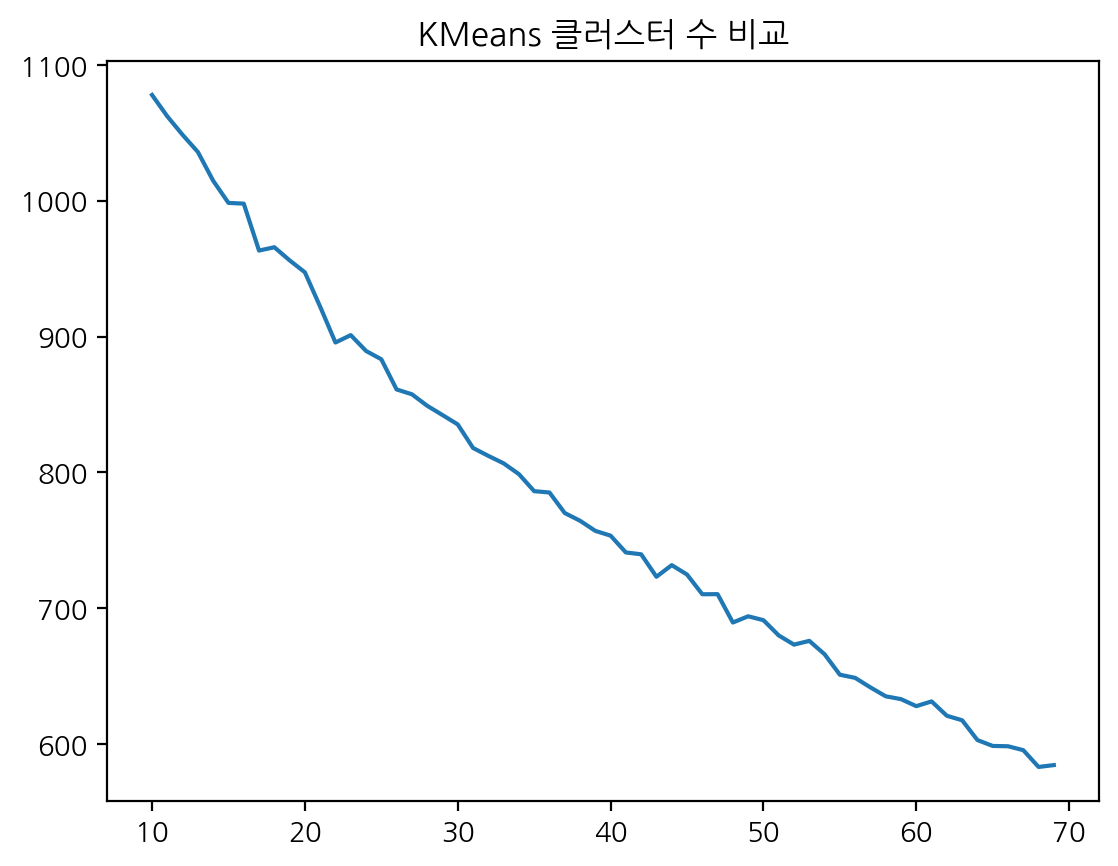

In [37]:
# 위에서 구한 값을 시각화
# x축에는 클러스터의 수를 y축에는 inertia 값을 넣어 그림

plt.plot(range(start, end), inertia)
plt.title("KMeans 클러스터 수 비교")

* 적정한 클러스터 갯수를 넣어 군집화 합니다.

In [38]:
# n_clusters 에 적절한 값을 넣어줌
# fit.predict 를 하고 결과를 cluster 라는 새로운 컬럼에 담음
n_clusters = 50
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(feature_tfidf)
prediction = kmeans.predict(feature_tfidf)
df["cluster"] = prediction

In [39]:
# 클러스터 센터
cc = kmeans.cluster_centers_

In [40]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)

X_tsne = tsne.fit_transform(feature_tfidf)
X_tsne.shape

/Users/corazzon/codes/notebook/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/corazzon/codes/notebook/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(2410, 2)

In [41]:
df2d = pd.DataFrame(X_tsne, columns=['x', 'y'])
df2d.shape

(2410, 2)

In [42]:
df2d["cluster"] = prediction
df2d.head()

,x,y,cluster
0,-95.526146,-38.058800,1
1,7.299818,22.858131,1
2,21.982355,-23.264963,1
3,5.814065,-5.318383,1
4,-5.382313,1.509442,1


In [43]:
df2d["cluster"] = df2d["cluster"].astype(int)

In [44]:
# df["cluster"] 의 빈도수를 value_counts로 세어봅니다.
df["cluster"].value_counts().head(10)

1     1704
6       44
2       41
17      36
3       32
16      28
9       27
12      26
4       24
22      23
Name: cluster, dtype: int64

### MiniBatchKMeans
* [Comparison of the K-Means and MiniBatchKMeans clustering algorithms — scikit-learn documentation](https://scikit-learn.org/stable/auto_examples/cluster/plot_mini_batch_kmeans.html)

In [45]:
# batch_size 를 쓸 수 있는 MiniBatchKMeans 로 군집화
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
b_inertia = []
silhouettes = []

# 적절한 클러스터의 갯수를 알기 위해 inertia 값을 구함
# trange 를 통해 시작과 끝 값을 지정해 주면 진행 정도를 알 수 있습니다.
# b_inertia 리스트에 cls.inertia_ 값을 넣어줍니다.
for i in trange(start, end):
    mkmeans = MiniBatchKMeans(n_clusters=i, random_state=42)
    mkmeans.fit(feature_tfidf)
    b_inertia.append(mkmeans.inertia_)
    silhouettes.append(silhouette_score(feature_tfidf, mkmeans.labels_))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:14<00:00,  4.14it/s]


Text(0.5, 1.0, 'MiniBatchKMeans 클러스터 수 비교')

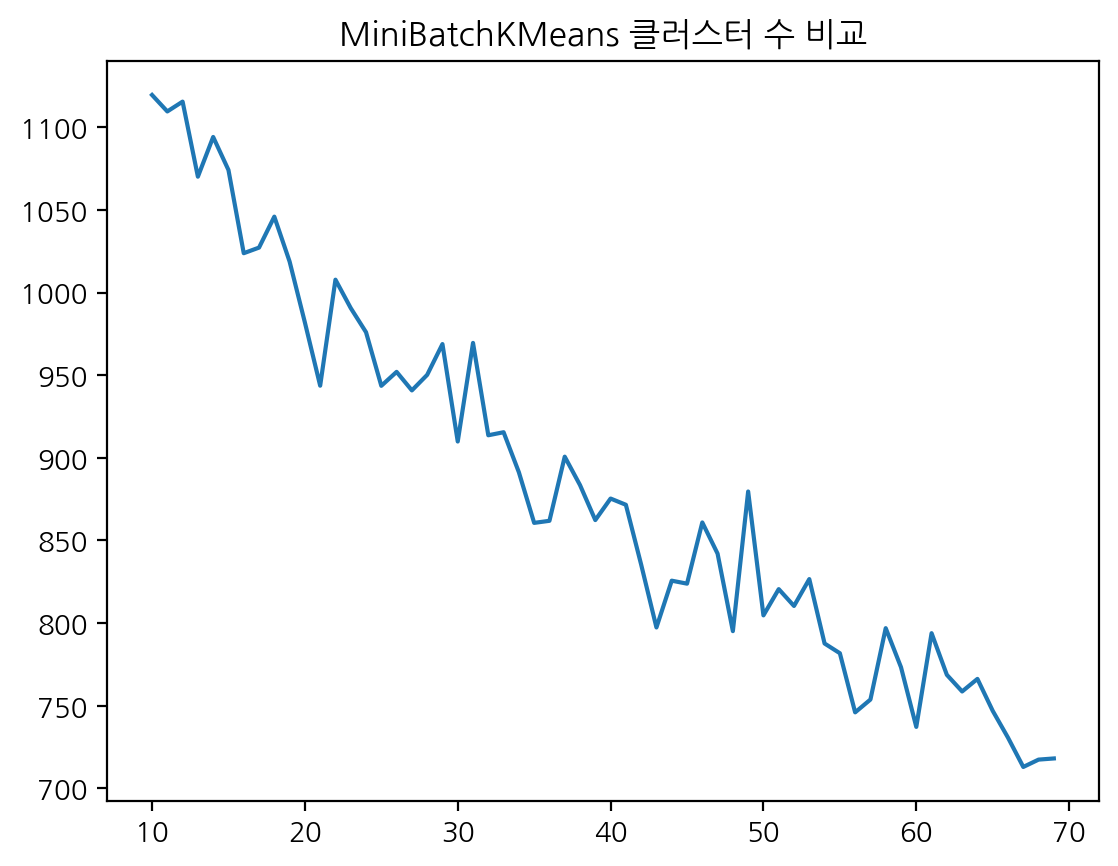

In [46]:
# 위에서 구한 값을 시각화 합니다.
# x축에는 클러스터의 수를 y축에는 b_inertia 값을 넣어 그립니다.
plt.plot(range(start, end), b_inertia)
plt.title("MiniBatchKMeans 클러스터 수 비교")

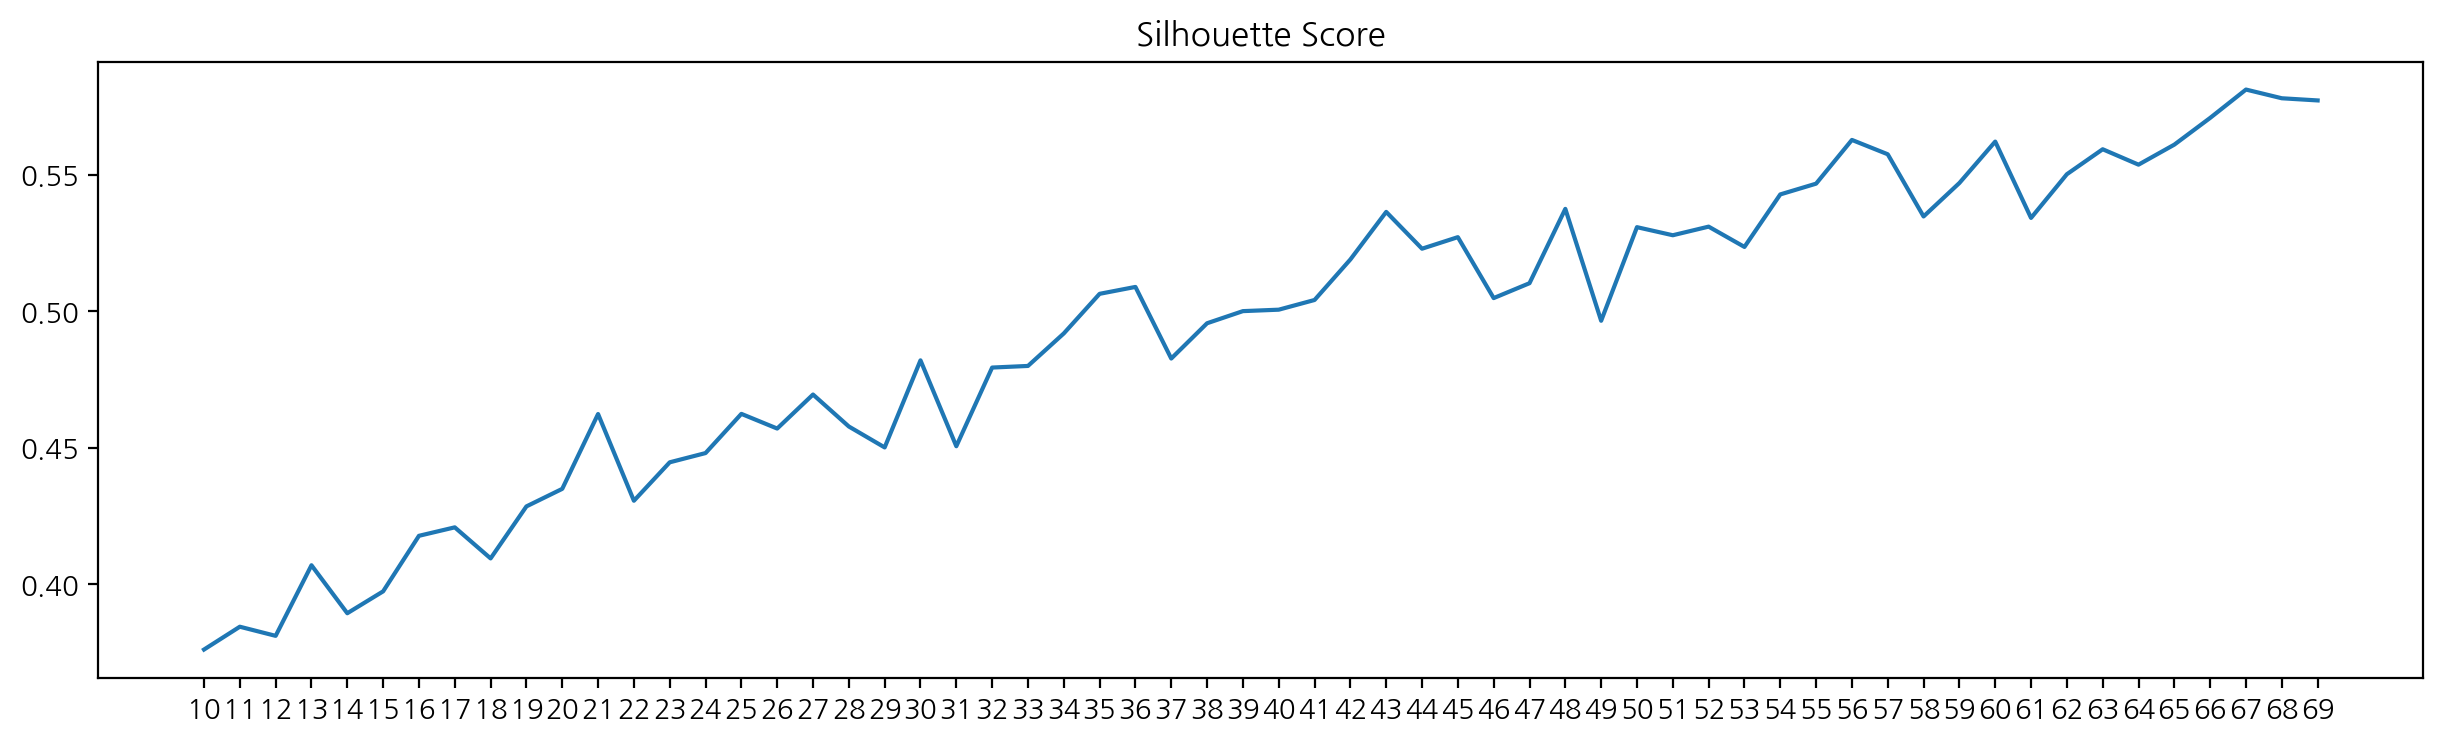

In [47]:
plt.figure(figsize=(15, 4))
plt.title('Silhouette Score')
plt.plot(range(start, end), silhouettes)
plt.xticks(range(start, end))
plt.show()

In [48]:
# MiniBatchKMeans 를 통해 학습
# 결과를 bcluster 라는 변수에 저장
mkmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42)
mkmeans.fit(feature_tfidf)
prediction = mkmeans.predict(feature_tfidf)
df["bcluster"] = prediction

In [49]:
# bcluster의 빈도수
df["bcluster"].value_counts().head(10)

25    1108
0      243
3      147
9       76
7       64
38      48
1       44
47      39
27      37
22      36
Name: bcluster, dtype: int64

In [50]:
# 어떤 강좌명이 있는지 특정 클러스터의 값을 봄  
df.loc[df["bcluster"] == 21, "course"].value_counts().head(1)

데이터 분석가 가 되고 싶은 현업 종사자 입니다. 2020년 목표는 파이썬을 통한 콜드/핫 데이터의 전처리 능력 습득, 데이터 유형과 목적에 맞는 머신러닝 알고리즘을 적용한 모델링 구축 입니다. \n관심있는 강의는 ***의 파이썬 실전 활용 입니다.    1
Name: course, dtype: int64

In [51]:
df.loc[df["bcluster"] == 21, ["bcluster", "cluster", "course"]]

,bcluster,cluster,course
567,21,9,데이터 분석가 가 되고 싶은 현업 종사자 입니다. 2020년 목표는 파이썬을 통한 ...


In [52]:
df.loc[df["bcluster"] == 24, ["bcluster", "cluster", "origin_text", "course"]].tail(10)

,bcluster,cluster,origin_text,course
900,24,18,C언어 공부 할래요~\n#관심강의 : ***의 따라하며 배우는 C언어,***의 따라하며 배우는 c언어
955,24,18,올해는 꼭 리버싱 마스터가되어 대회참가하겠습니다 화이팅\n'***의 따라하며 배우는...,올해는 꼭 리버싱 마스터가되어 대회참가하겠습니다 화이팅\n'***의 따라하며 배우는...
1068,24,18,올해에는 저만의 서비스를 꼭 만들어보고 싶습니다~!\n\n강의명 : ***의 따라하...,올해에는 저만의 서비스를 꼭 만들어보고 싶습니다~!\n\n강의명 ***의 따라하며...
1326,24,18,올해부터 새롭게 C언어 공부를 시작한 비전공자 학생입니다. 컴퓨터 언어가 무엇인지 ...,올해부터 새롭게 c언어 공부를 시작한 비전공자 학생입니다. 컴퓨터 언어가 무엇인지 ...
1398,24,18,소프트웨어 전공 학생입니다 \n개강하기전에 꼭 C언어 강의를 수료해서 이번 학기 ...,***의 따라하며 배우는 c언어
1428,24,18,고등학교를 졸업한 예비 컴퓨터 공학도입니다. 그동안 입시를 준비하며 ps공부를 병행...,***의 따라하며 배우는 c언어
1489,24,18,요즘 들어 동아리 활동하는 데 C언어를 많이 활용하는 것 같아서 몇 달 전부터 C언...,***의 따라하며 배우는 c언어
1511,24,18,프로그래밍에 흥미를 가지게 되어 인프런을 이용하게 된 학생입니다.\n*** 강사님이...,***의 따라하며 배우는 c언어
2238,24,18,경영학과 졸업생인데 개발자로 진로를 변경하기로 했습니다. 올해 안에 꼭 백엔드 개발...,"***의 따라하며 배우는 c언어, ***의 스프링 강의 전부, ***님의 jp..."
2426,24,18,"2020년 공부 목표 :\nc언어, c++ ,알고리즘과 자료구조의 탄탄한 기본을 다...",***의 따라하며 배우는 c언어


### 클러스터 예측 정확도 확인하기

In [53]:
# n_clusters 위에서 정의한 클러스터 수를 사용
feature_array = feature_vector.toarray()
# 예측한 클러스터의 유니크 값
labels = np.unique(prediction)
df_cluster_score = []
df_cluster = []
for label in labels:
    id_temp = np.where(prediction==label) # 예측한 값이 클러스터 번호와 매치 되는 것을 가져옴
    x_means = np.mean(feature_array[id_temp], axis = 0) # 클러스터의 평균 값을 구함
    sorted_means = np.argsort(x_means)[::-1][:n_clusters] # 값을 역순으로 정렬해서 클러스터 수 만큼 가져옴
    features = vectorizer.get_feature_names_out()
    best_features = [(features[i], x_means[i]) for i in sorted_means] 
    # 클러스터별 전체 스코어
    df_score = pd.DataFrame(best_features, columns = ['features', 'score'])
    df_cluster_score.append(df_score)
    # 클러스터 대표 키워드
    df_cluster.append(best_features[0])

In [54]:
# 개별 클러스터에서 점수가 가장 높은 단어를 추출 아래 점수가 클수록 예측 정확도가 높음
# MiniBatchKMeans 로 예측한 값 기준
pd.DataFrame(df_cluster, columns = ['features', 'score']).sort_values(by=["features", "score"], ascending=False)

,features,score
47,프로그래밍과 자바스크립트 es6,1.102564
18,프로그래밍 시작하기 파이썬 입문,1.000000
36,표준 jpa 프로그래밍,1.000000
39,파이썬을 이용한 it 해킹과,1.000000
21,파이썬 실전 활용,1.000000
32,파이썬 실전 활용,1.000000
28,코틀린 기반 안드로이드,0.315789
45,코드를 조작하는 다양한 방법,1.000000
12,취업을 위해 제대로 배워보는,0.117647
19,취업을 위한 알고리즘,1.000000


In [55]:
# score 정확도가 1이 나온 클러스터를 찾아봄 - 같은 강좌끼리 묶였는지 확인 함
df.loc[df["bcluster"] == 28, ["bcluster", "cluster", "origin_text", "course"]]

,bcluster,cluster,origin_text,course
111,28,1,번 아웃에 빠졌어요. 새로운거 해보려구요.\n#관심강의 : 유니티 기초 강좌 - 기...,유니티 기초 강좌 - 기획부터 사용까지
122,28,1,R 데이터분석의 전문가가 되고싶어용\n#관심강의 : R로 하는 텍스트마이닝 (Top...,r로 하는 텍스트마이닝 (top keyword부터 감성분석까지)
459,28,1,웹 프론트엔드 개발자가 되기 위해 공부하고 있습니다.\n#관심강의 : Redux v...,redux vs mobx (둘 다 배우자!)
620,28,1,컴공 대학교 졸업후 진로에 대해 생각해 볼 틈도 없이 바로 취업을 했습니다. 모바일...,컴공 대학교 졸업후 진로에 대해 생각해 볼 틈도 없이 바로 취업을 했습니다. 모바일...
992,28,1,일반회사원으로 일하고 있는데요. \n자기개발 및 커리어 전환을 위해서 개발자관련 강...,"r로 하는 텍스트마이닝 (top keyword부터 감성분석까지), 쉽고 빠르게 끝..."
996,28,1,코틀린으로 역량을 강화시켜서 기가 막히고 코가 막히는 앱을 만들고 싶습니다. ......,코틀린 기반 안드로이드 앱개발 고급 3단계
1028,28,1,2020 올해의 목표는 제가 만든 웹서비스를 출시해보는 것입니다. 웹 서비스를 만드...,2020 올해의 목표는 제가 만든 웹서비스를 출시해보는 것입니다. 웹 서비스를 만드...
1314,28,1,공부열심히 해서 올해는 꼭 개인 안드로이드 앱을 개발 & 배포하겠습니다 !!\n/ ...,공부열심히 해서 올해는 꼭 개인 안드로이드 앱을 개발 & 배포하겠습니다 !!\n/ ...
1319,28,1,임베디드 개발자인데 모바일로 업무환경을 바꾸려고 합니다! 성공적인 전업이 되었으면...,코틀린 기반 안드로이드 앱개발 기본 1단계
1385,28,1,"프론트 개발자였다가, 최근에 앱 개발자가 되었습니다. 인프런과 함께 안드로이드를 마...","코틀린 기반 안드로이드 앱 1~3, flutter 입문~중급"


## WordCloud
* [amueller/word_cloud: A little word cloud generator in Python](https://github.com/amueller/word_cloud)
* 설치 방법 : [Wordcloud :: Anaconda Cloud](https://anaconda.org/conda-forge/wordcloud)

In [56]:
# pip install wordcloud

In [57]:
# 불용어 - 자주 등장하지만 의미가 크지 않아 제외하고 싶은 텍스트
stopwords = ["관심 강의", "관심강의", "관심", "강의", "강좌", "강의를",
             "올해", "올해는", "열심히", "공부를", "합니다", "하고", "싶어요", 
             "있는", "있습니다", "싶습니다", "2020년"]
# 불용어를 제거하지 않고 그리려면 아래 주석을 풀어서 stopword 변수에 덮어쓰기를 합니다.
# stopwords = []
from wordcloud import WordCloud
    

def display_word_cloud(data, width=1200, height=500):
    
    word_draw = WordCloud(
        font_path=r"/Library/Fonts/NanumBarunGothic.ttf",
        width=width, height=height,
        stopwords=stopwords, 
        background_color="white",
        random_state=42
    )
    word_draw.generate(data)

    plt.figure(figsize=(15, 7))
    plt.imshow(word_draw)
    plt.axis("off")
    plt.show()

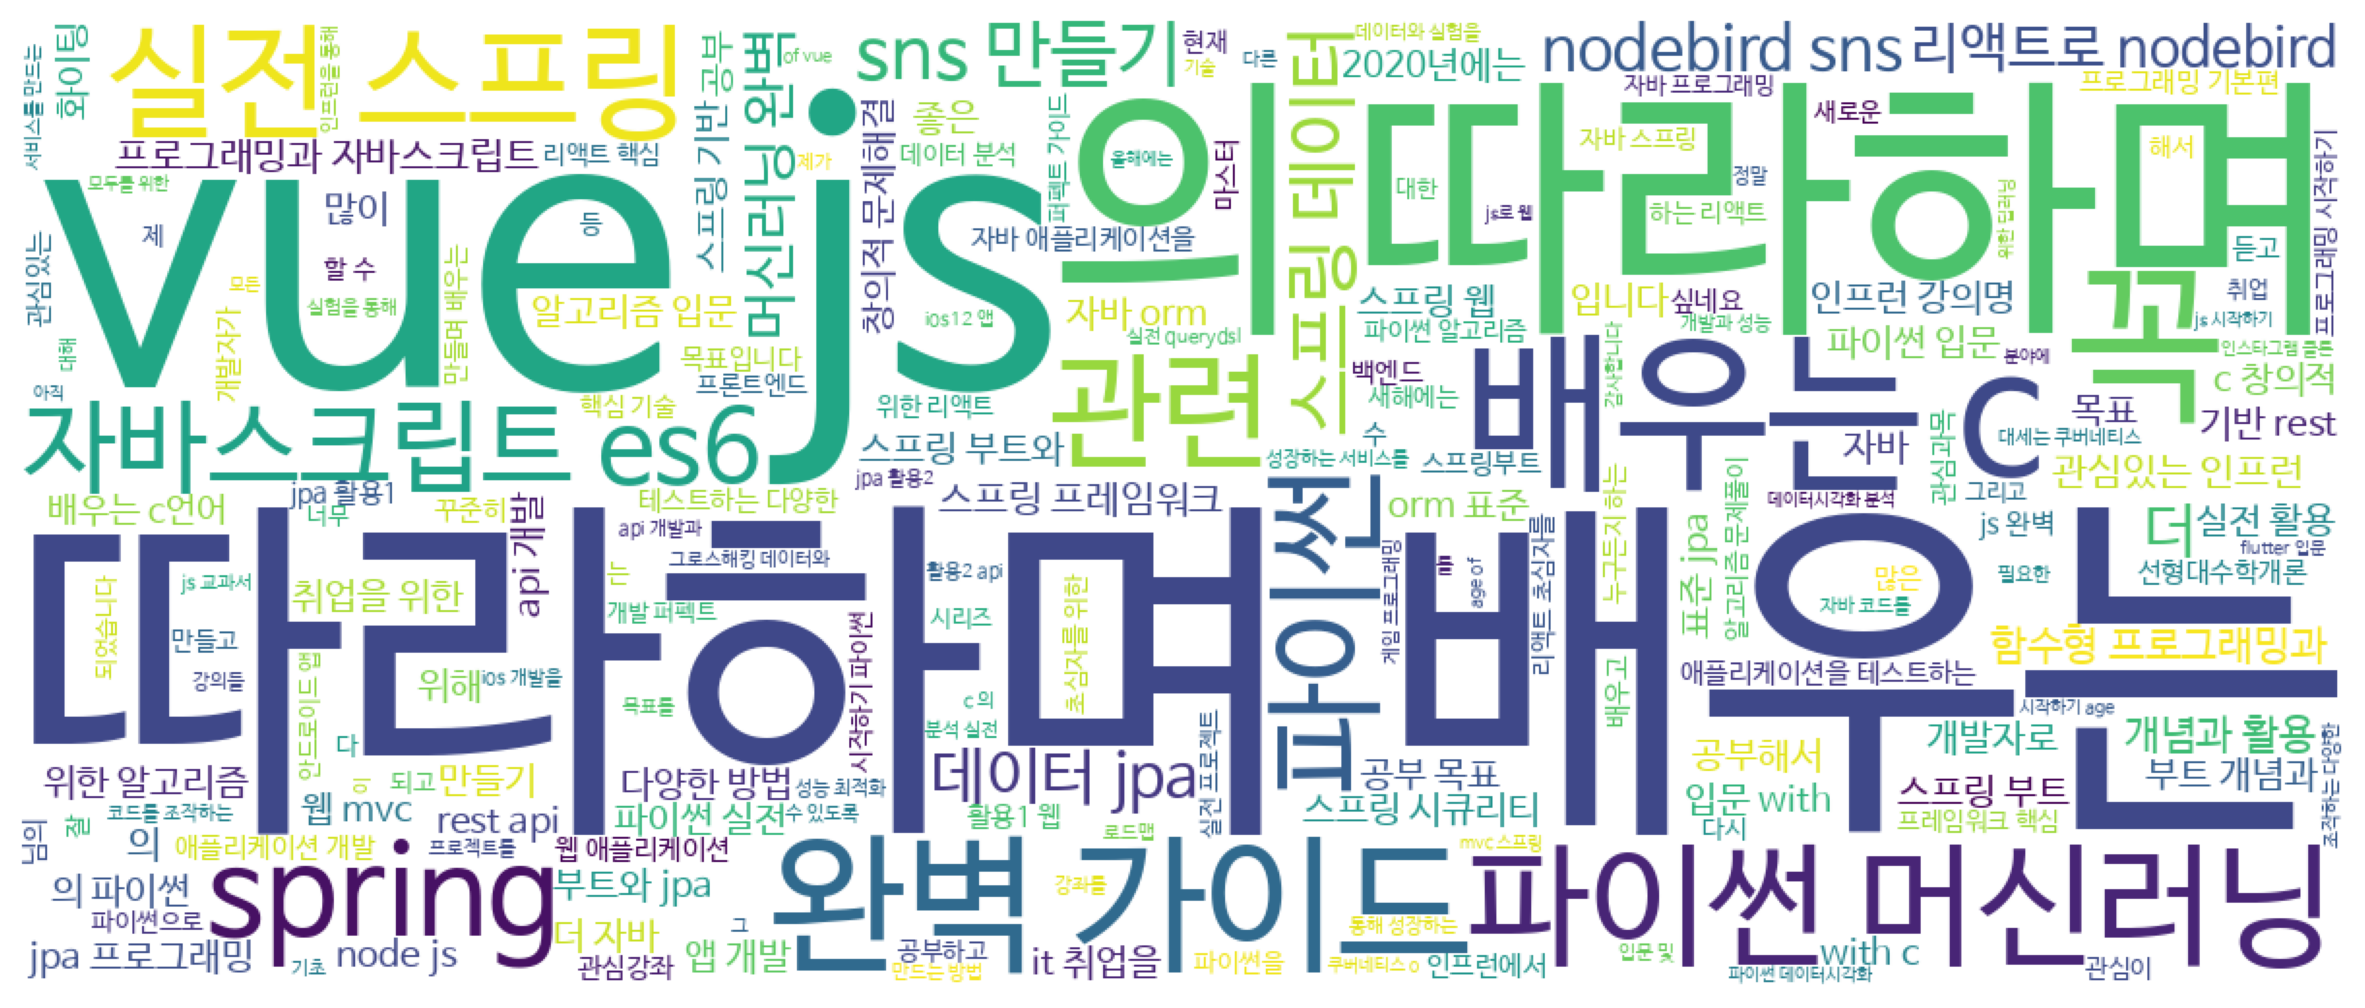

In [58]:
course_text = " ".join(df["course"])
display_word_cloud(course_text)